# Distributed Commuting Simple Example

This notebook illustrates a simple example of the distributed commuting tool, a series a functions used to retrieve rightmove listings within a certain travel time of a point of interest.

In [16]:
from IPython.display import Image, display

In [7]:
# read functions

%run appfunctions.py
%run rmscraper.py

In [8]:
# fill in property/commute critera

my_postcode = "WA13 0SP"
travel_mode = 'driving-car'
commute_minutes = 10
maxBedrooms = 3
minBedrooms = 3
maxPrice = 400000
minPrice = 300000
propertyTypes='detached'

In [9]:
# translate postcode to long lat coords

long_lat = address_to_lat_long(my_postcode, lat_long=False)
long_lat

(-2.5048355, 53.359320139999994)

In [10]:
# create driving time polygon around coordinate. Map and retrieve polygon coords

#%set_env ors_api_key="your ors api key"
m, polygon_coords = create_isochrone(long_lat, travel_mode, commute_minutes, draw_map=True)


In [11]:
m

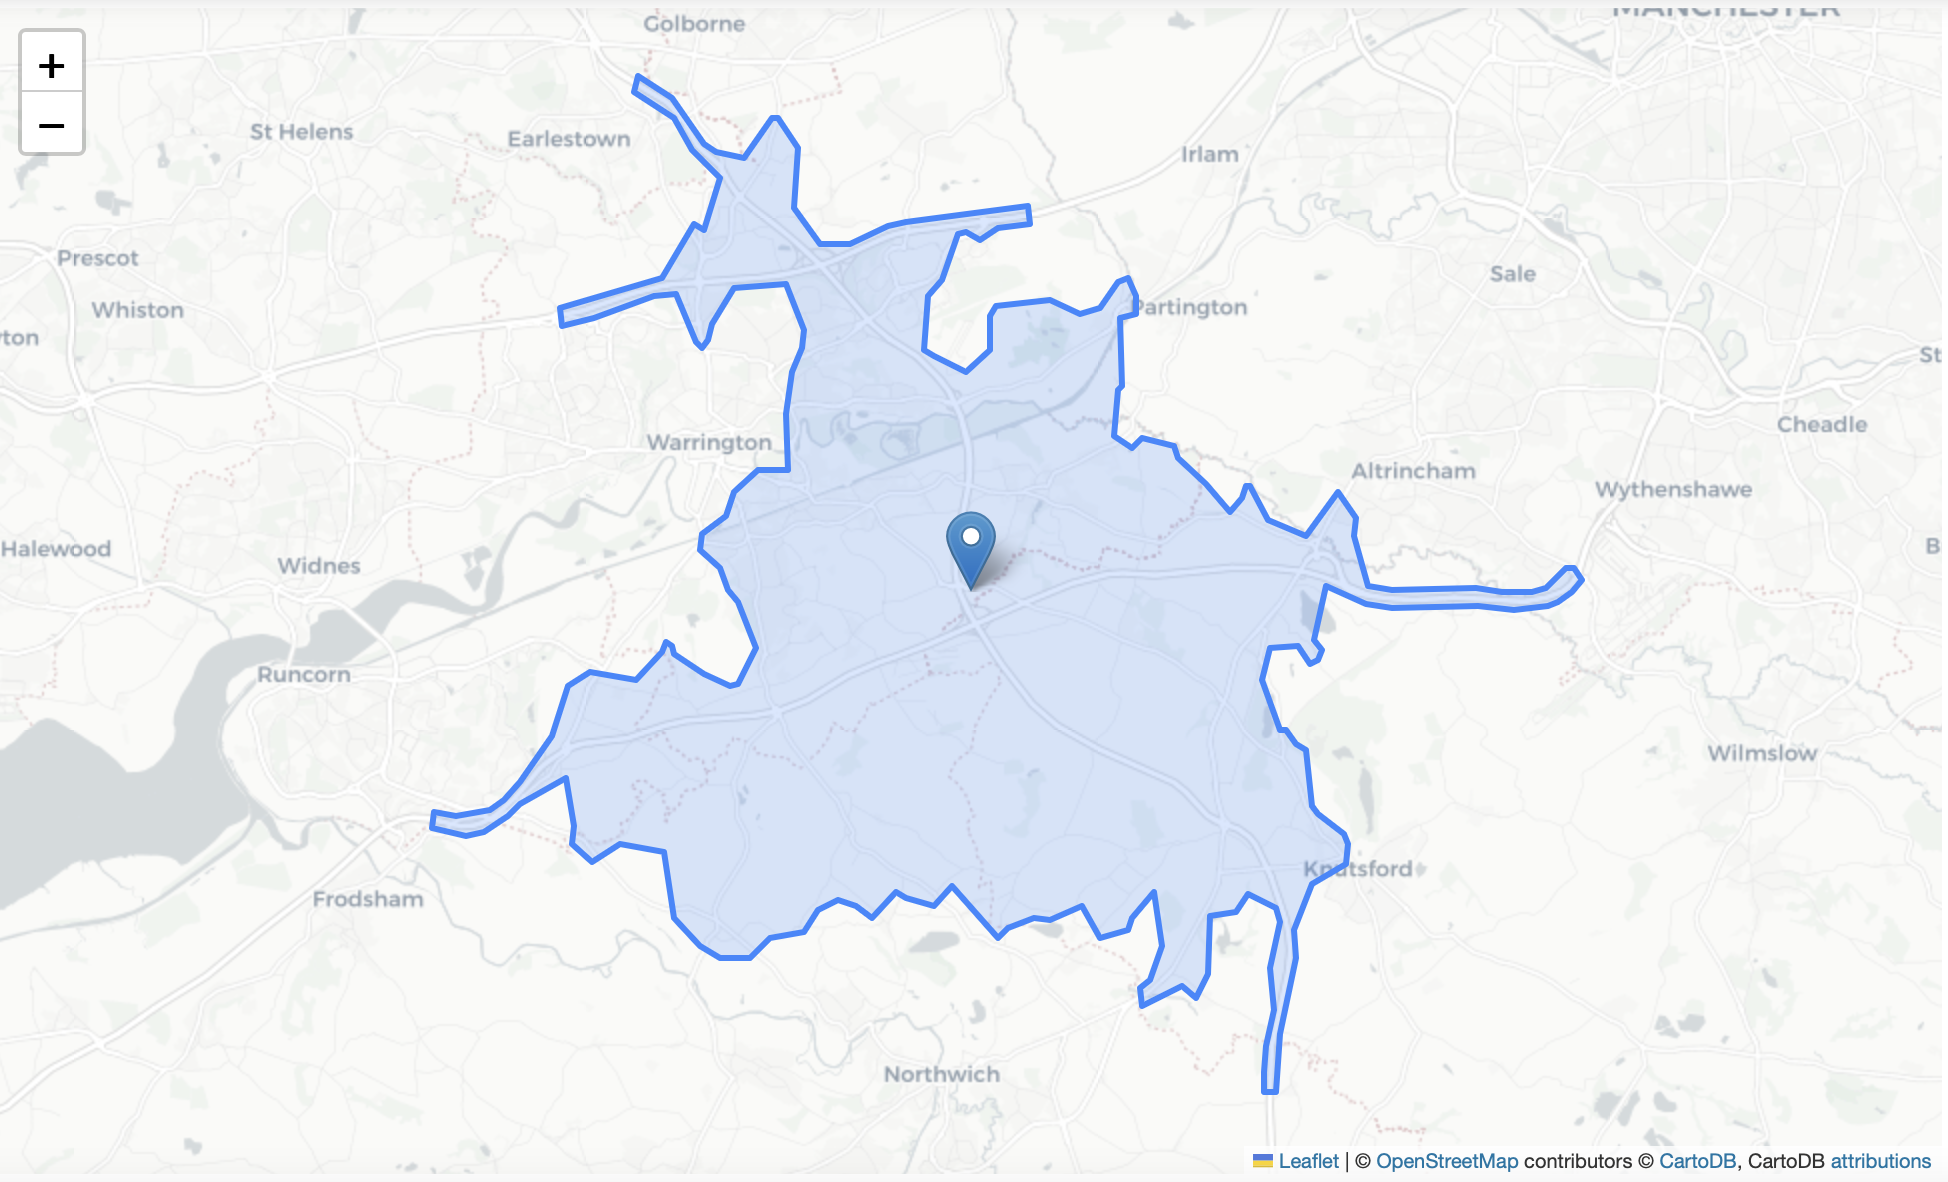

In [15]:
# display as static image

display(Image(filename='maps/polygon.png'))

In [99]:
polygon_coords[0:5]

[[-2.689612, 53.310675],
 [-2.68678, 53.310247],
 [-2.684452, 53.309895],
 [-2.681071, 53.309418],
 [-2.67822, 53.309254]]

In [100]:
# calculate furthest point from coordinate. We need this to search rightmove.

furthest_point_dist = furthest_point_distance(long_lat, polygon_coords)
furthest_point_dist

8.678519237640463

In [101]:
# round this up to the nearest rightmove search area value

rightmove_miles=[0.25,0.5,1,3,5,10,15,20]
rightmove_area_miles = round_up_to_nearest(furthest_point_dist, rightmove_miles)
rightmove_area_miles

10

In [102]:
# rightmove encodes postcodes. Find location id:

pc_location_id = get_postcode_id(my_postcode)
pc_location_id

'1662484'

In [103]:
# formulate rightmove scraping link:

final_link = f"https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=POSTCODE^{pc_location_id}&maxBedrooms={maxBedrooms}&minBedrooms={minBedrooms}&maxPrice={maxPrice}&minPrice={minPrice}&radius={rightmove_area_miles}&propertyTypes={propertyTypes}"
final_link

'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=POSTCODE^1662484&maxBedrooms=3&minBedrooms=3&maxPrice=400000&minPrice=300000&radius=10&propertyTypes=detached'

In [104]:
# scrape rightmove for the all listings available on this link:

rm = RightmoveData(final_link)
houses_for_sale = rm.get_results
houses_for_sale.head(3)

price                               type   
0  325000  3 bedroom detached house for sale  \
1  400000  3 bedroom detached house for sale   
2  400000  3 bedroom detached house for sale   

                                       address   
0  Poulton Crescent, Woolston, Warrington, WA1  \
1       Chester Road, Hartford, Northwich, CW8   
2            Jack Brady Close, Manchester, M23   

                                                 url   
0  http://www.rightmove.co.uk/properties/13555794...  \
1  http://www.rightmove.co.uk/properties/13297940...   
2  http://www.rightmove.co.uk/properties/13501610...   

                                           agent_url postcode full_postcode   
0  http://www.rightmove.co.uk/estate-agents/agent...      WA1           NaN  \
1  http://www.rightmove.co.uk/estate-agents/agent...      CW8           NaN   
2  http://www.rightmove.co.uk/estate-agents/agent...      M23           NaN   

   number_bedrooms                search_date  
0                3 2023-06-05 11:53:06.916095  
1                3 2023-06-05 11:53:06.916095  
2                3 2023-06-05 11:53:06.916095

In [105]:
# translate property address info to long lat

houses_for_sale[['longitude', 'latitude']] = houses_for_sale['address'].apply(address_to_long_lat_bing).apply(pd.Series)
houses_for_sale.head(3)

price                               type   
0  325000  3 bedroom detached house for sale  \
1  400000  3 bedroom detached house for sale   
2  400000  3 bedroom detached house for sale   

                                       address   
0  Poulton Crescent, Woolston, Warrington, WA1  \
1       Chester Road, Hartford, Northwich, CW8   
2            Jack Brady Close, Manchester, M23   

                                                 url   
0  http://www.rightmove.co.uk/properties/13555794...  \
1  http://www.rightmove.co.uk/properties/13297940...   
2  http://www.rightmove.co.uk/properties/13501610...   

                                           agent_url postcode full_postcode   
0  http://www.rightmove.co.uk/estate-agents/agent...      WA1           NaN  \
1  http://www.rightmove.co.uk/estate-agents/agent...      CW8           NaN   
2  http://www.rightmove.co.uk/estate-agents/agent...      M23           NaN   

   number_bedrooms                search_date  longitude   latitude  
0                3 2023-06-05 11:53:06.916095  -2.533842  53.404028  
1                3 2023-06-05 11:53:06.916095  -2.555991  53.241685  
2                3 2023-06-05 11:53:06.916095  -2.298743  53.386636

In [106]:
# filter houses inside/outside of driving time polygon 

houses_for_sale['in_polygon'] = polygon_filter(houses_for_sale, polygon_coords)
houses_for_sale.head(3)

price                               type   
0  325000  3 bedroom detached house for sale  \
1  400000  3 bedroom detached house for sale   
2  400000  3 bedroom detached house for sale   

                                       address   
0  Poulton Crescent, Woolston, Warrington, WA1  \
1       Chester Road, Hartford, Northwich, CW8   
2            Jack Brady Close, Manchester, M23   

                                                 url   
0  http://www.rightmove.co.uk/properties/13555794...  \
1  http://www.rightmove.co.uk/properties/13297940...   
2  http://www.rightmove.co.uk/properties/13501610...   

                                           agent_url postcode full_postcode   
0  http://www.rightmove.co.uk/estate-agents/agent...      WA1           NaN  \
1  http://www.rightmove.co.uk/estate-agents/agent...      CW8           NaN   
2  http://www.rightmove.co.uk/estate-agents/agent...      M23           NaN   

   number_bedrooms                search_date  longitude   latitude   
0                3 2023-06-05 11:53:06.916095  -2.533842  53.404028  \
1                3 2023-06-05 11:53:06.916095  -2.555991  53.241685   
2                3 2023-06-05 11:53:06.916095  -2.298743  53.386636   

   in_polygon  
0        True  
1       False  
2       False

In [107]:
# map houses inside/outside polygon 

m = map_houses(long_lat, travel_mode, commute_minutes, houses_for_sale, rightmove_area_miles)
m

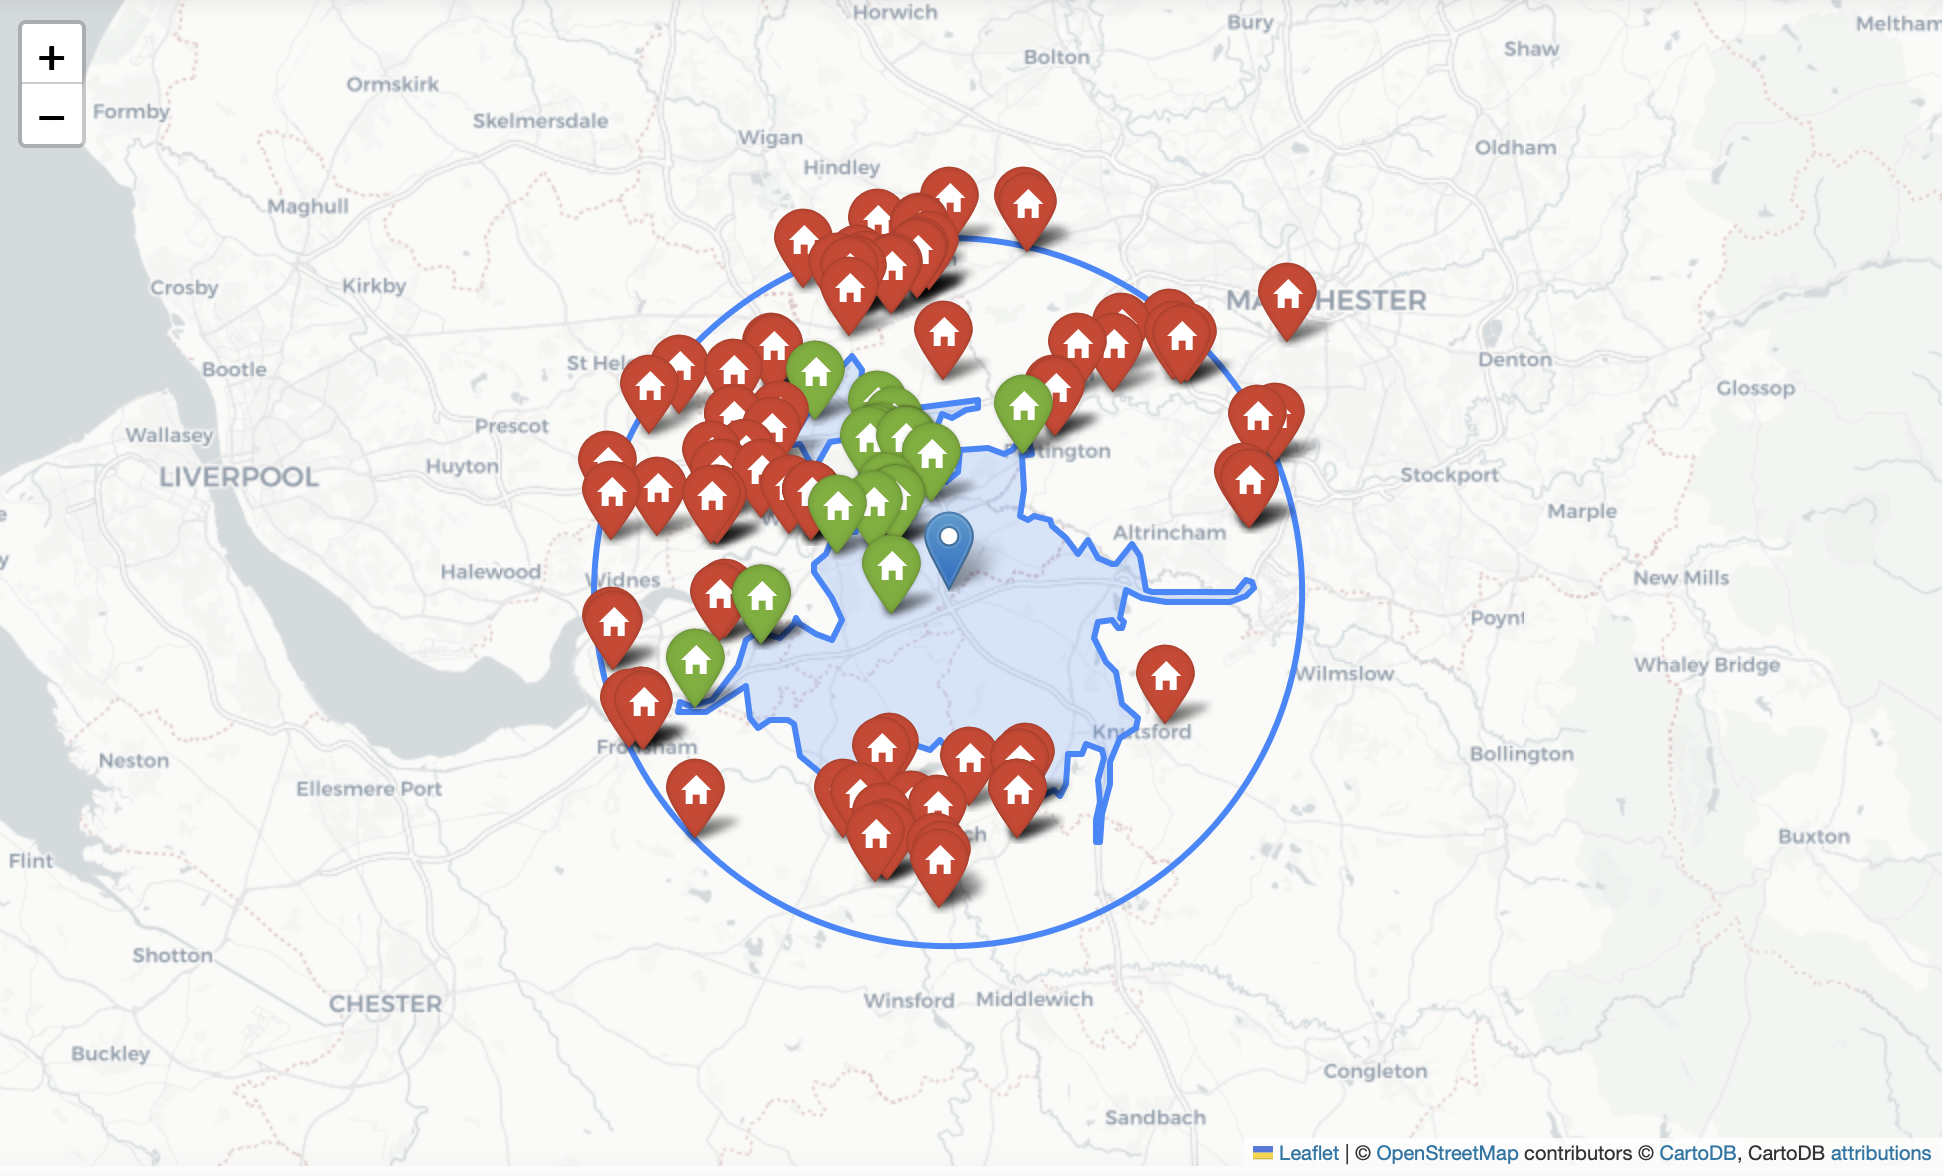

In [17]:
# display as static image. For interactive version, download from .html file from 'maps'

display(Image(filename='maps/houses.png'))